# Setting Up

## Installing Sherpa

* Install Anaconda.
* `$ conda install -c sherpa sherpa`

## Installing Sunxspex

* `$ git clone https://github.com/abhilash-sw/sunxspex.git`
* `cd sunxspex`
* `$ git checkout manipal_workshop`
* `cd sunxspex`
* Open thermal.py and change `abs_path` (line no. 17) variable to current directory path (eg /home/mcns/manipal_workshop_x_ray/sunxspex/sunxspex)
* Open io.py and change `abs_path` variable to current directory path
* `cd ..`
* `python setup.py install`

# [XSM Data](https://www.prl.res.in/ch2xsm/xsm_instrument)

Solar X-ray Monitor (abbreviated as XSM) observes the Sun as a star and measures the solar X-ray spectrum in the energy range of 1-15 keV with an energy resolution of ~175 eV at 5.9 keV and a time cadence of one second. The broadband soft X-ray spectra with XSM provides diagnostics of the solar corona at various levels of solar activity from quiescent Sun to large solar flares. 

In [110]:
from sunxspex.thermal import thermal_emission
from sunxspex import emission
import astropy.units as u
import numpy as np

from sherpa.astro.instrument import RSPModelPHA
from sherpa.astro.instrument import RSPModelNoPHA
from sherpa.astro.io import read_arf, read_rmf, read_pha
from sherpa.models import model
from sherpa.astro.instrument import Response1D
from sherpa.stats import Chi2, CStat, Cash

from sherpa.fit import Fit
from astropy.io import fits
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['science','notebook','grid'])

## Lightcurve Data

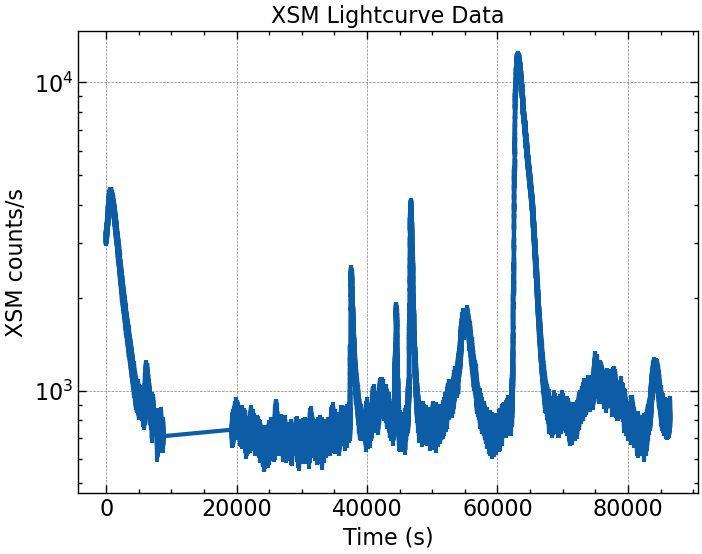

In [111]:
hdus = fits.open('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.lc')
lc_data = hdus[1].data
tm = lc_data['TIME'] - np.min(lc_data['TIME'])
rate = lc_data['RATE']
rate_err = lc_data['ERROR']

fig, ax = plt.subplots()
# fig.set_size_inches(16,9)
ax.errorbar(tm,rate,yerr=rate_err,lw=3)
ax.set_yscale('log')
# ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('XSM counts/s')
ax.set_title('XSM Lightcurve Data');

## Spectral Data

In [112]:
all_phas = read_pha('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',use_errors=True);
print(f'Number of spectra found: {len(all_phas)}')

Number of spectra found: 1232


In [113]:
pha_tmp1 = all_phas[200]
pha_tmp2 = all_phas[700]

In [114]:
from sherpa.plot import *

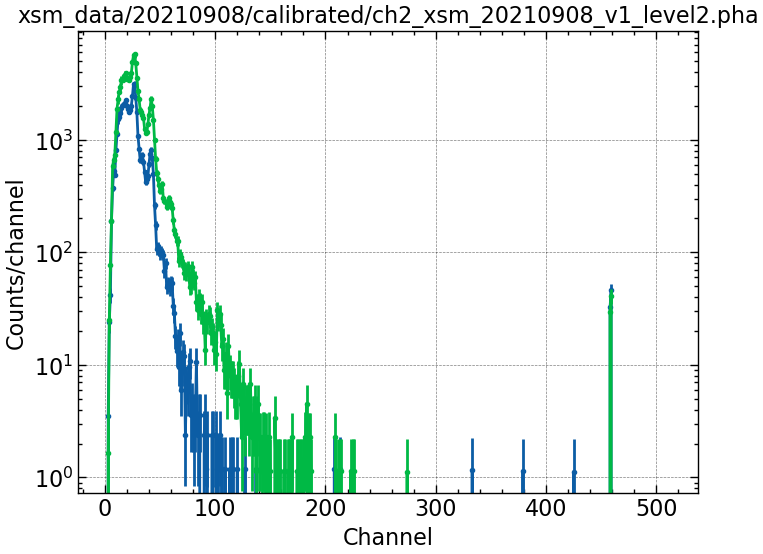

In [115]:
dplot1 = DataPlot()
dplot1.prepare(pha_tmp1)
dplot1.plot(ylog=True,linestyle='solid')
dplot1.prepare(pha_tmp2)
dplot1.overplot(ylog=True,linestyle='solid')


## Instrument Response

In [116]:
rmf = read_rmf('caldb/CH2xsmrspwitharea_open20191214v01.rsp')
rmf

<DataRMF data set instance 'caldb/CH2xsmrspwitharea_open20191214v01.rsp'>

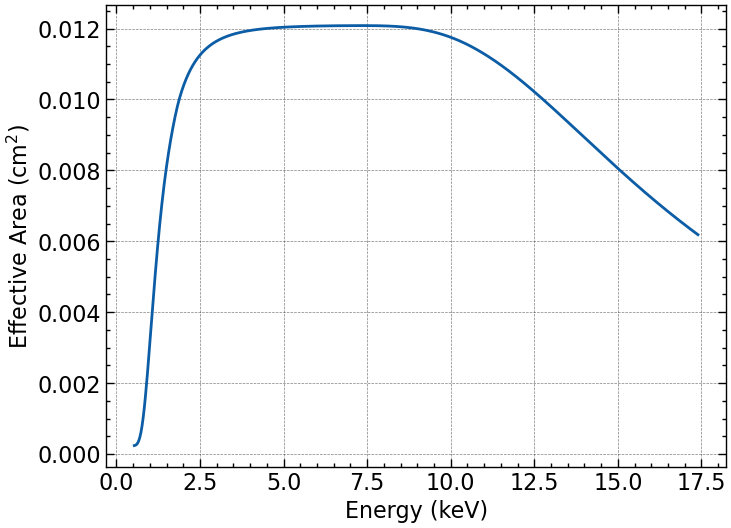

In [117]:
fig, ax = plt.subplots()
ax.plot(rmf.e_max,rmf.get_y())
ax.set_xlabel('Energy (keV)')
ax.set_ylabel(r'Effective Area (cm$^2$)');

In [118]:
pha_tmp1.set_rmf(rmf)
pha_tmp1.set_analysis('energy')

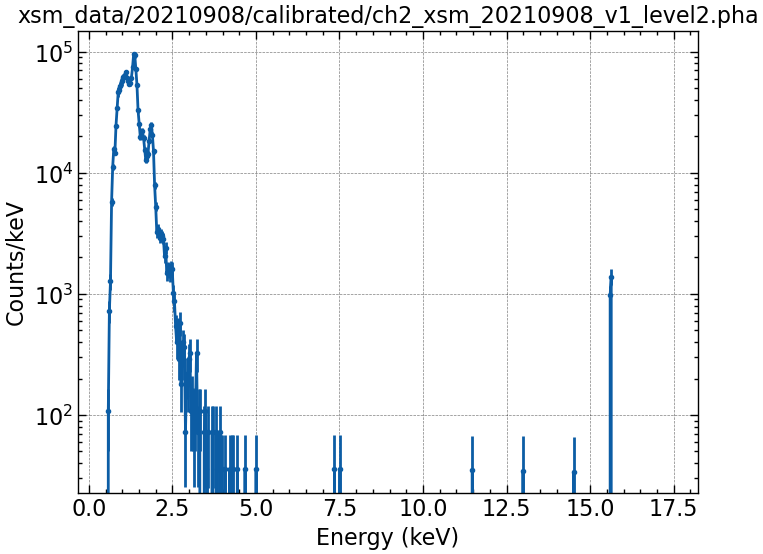

In [119]:
dplot1 = DataPlot()
dplot1.prepare(pha_tmp1)
dplot1.plot(ylog=True,linestyle='solid')


### Data Seletion

In [120]:
effarea=np.loadtxt('caldb/xsm_onaxis_effective_area.txt')



def xsm_gen_lc(spec_file,ene_lo,ene_hi):
    hdu1 = fits.open(spec_file)
    hdu=fits.BinTableHDU.from_columns(hdu1[1].columns)

    data=hdu.data

    time_xsm = (data['TSTART']+data['TSTOP'])/2.
    tbinsize=(data['TSTOP'][0]-data['TSTART'][0])
    
    exposure=data['EXPOSURE']
    
    ns=len(data)
    fluxlc = np.zeros(ns)
    countlc = np.zeros(ns)
    
    ene=np.arange(0,512)*0.033+0.5+0.033/2.0 # Midpoint energy of PI bins
    
    kev2erg=1.6021e-9
    cgs2si=0.001

    startch=int((ene_lo-0.5)/0.033)
    stopch=int((ene_hi-0.5)/0.033)


    for i in range(0,ns):
        spec = data['COUNTS'][i]/data['EXPOSURE'][i]
        spec_ene = spec*ene/effarea
        fluxlc[i] = np.sum(spec_ene[startch:stopch])*kev2erg*cgs2si
        countlc[i] = np.sum(spec[startch:stopch])
    
    ## Select only bins with atleast half exposure for tbinsize >=10
    if (tbinsize >= 10.0):
        ind=(exposure  > max(exposure)/2.0)
        time_xsm=time_xsm[ind]
        fluxlc=fluxlc[ind]
        countlc = countlc[ind]
        exposure=exposure[ind]


    nbins=int(86400.0/tbinsize)
    
    tday0=int(time_xsm[0]/86400.0)*86400.0
    t0=(time_xsm[0]-int((time_xsm[0]-tday0)/tbinsize)*tbinsize)
    alltime=np.arange(0,nbins)*tbinsize+t0
    allflux=np.empty(nbins)
    allflux[:]=np.nan
    allcount=np.empty(nbins)
    allcount[:]=np.nan

    for i,t in enumerate(time_xsm):
        tbin=int((t-tday0)/tbinsize)
        allflux[tbin]=fluxlc[i]
        allcount[tbin]=countlc[i]

    return alltime, allflux, allcount


ene_lo = 1.551 #keV
ene_hi = 12.408 #keV

alltime, allflux, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',ene_lo,ene_hi)
alltime = alltime - alltime.min()

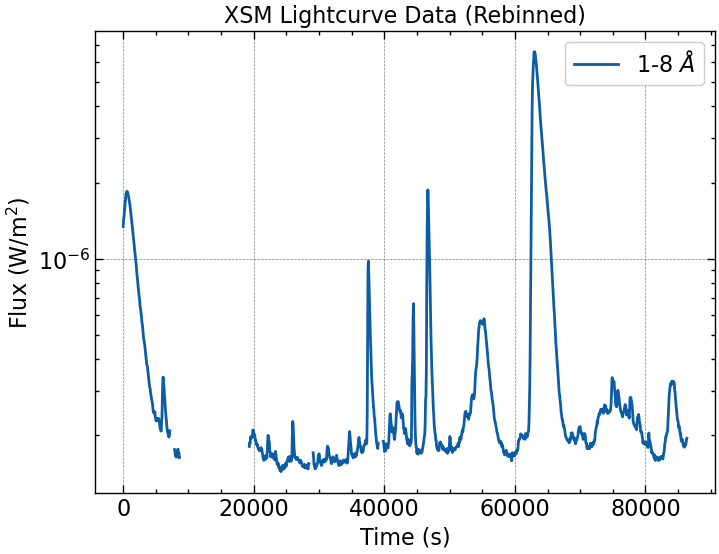

In [124]:
fig, ax = plt.subplots()
ax.semilogy(alltime,allflux,label=r'1-8 $\AA$')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.set_title('XSM Lightcurve Data (Rebinned)');
ax.legend();

### [Solar Flare C8.4](https://www.solarmonitor.org/goes_pop.php?date=20210909&type=xray)

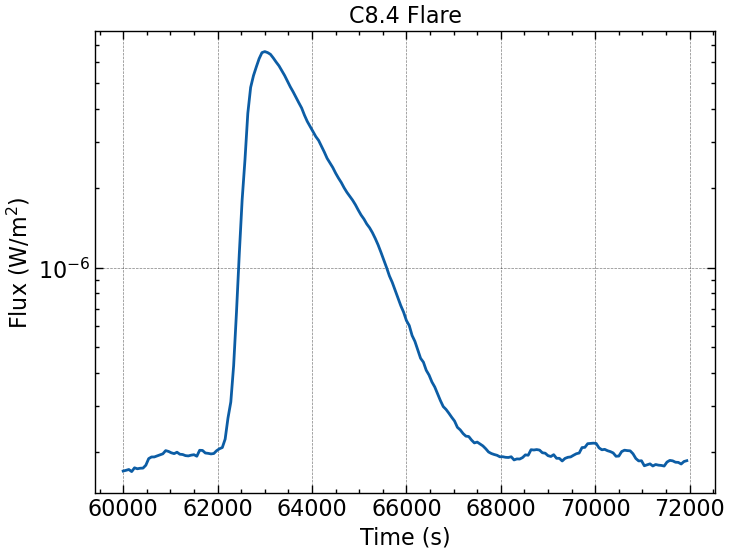

In [125]:
fig, ax = plt.subplots()
ax.semilogy(alltime[1000:1200],allflux[1000:1200])
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.set_title('C8.4 Flare');

In [126]:
alltime, allflux_1_3, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',1,3)
alltime, allflux_3_6, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',3,6)
alltime, allflux_6_10, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',6,10)
alltime, allflux_10_15, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',10,15)
alltime = alltime - alltime.min()

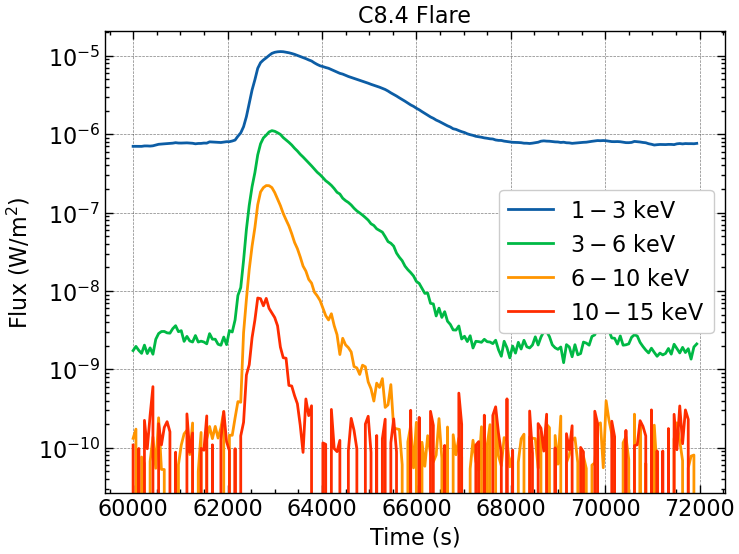

In [127]:
fig, ax = plt.subplots()
ax.semilogy(alltime[1000:1200],allflux_1_3[1000:1200],label=r'$1 - 3$ keV')
ax.semilogy(alltime[1000:1200],allflux_3_6[1000:1200],label=r'$3 - 6$ keV')
ax.semilogy(alltime[1000:1200],allflux_6_10[1000:1200],label=r'$6 - 10$ keV')
ax.semilogy(alltime[1000:1200],allflux_10_15[1000:1200],label=r'$10 - 15$ keV')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.legend()
ax.set_title('C8.4 Flare');

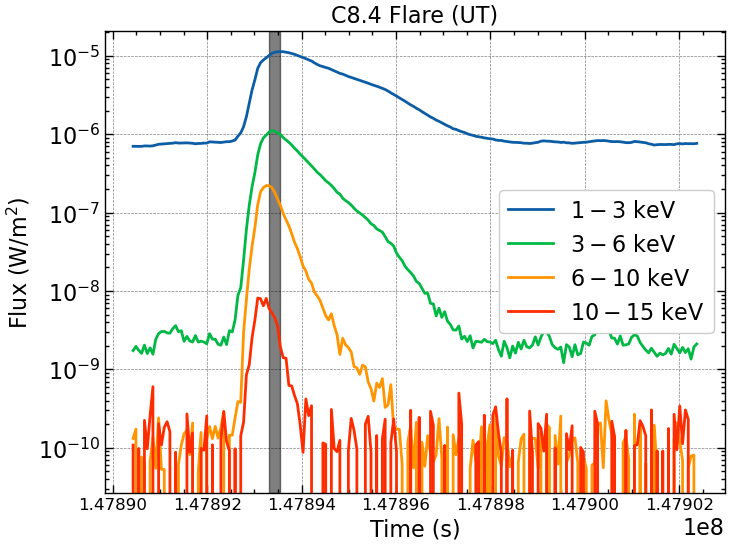

In [128]:
alltime, allflux_1_3, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',1,3)
alltime, allflux_3_6, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',3,6)
alltime, allflux_6_10, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',6,10)
alltime, allflux_10_15, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',10,15)
# alltime = alltime - alltime.min()
fig, ax = plt.subplots()
ax.semilogy(alltime[1000:1200],allflux_1_3[1000:1200],label=r'$1 - 3$ keV')
ax.semilogy(alltime[1000:1200],allflux_3_6[1000:1200],label=r'$3 - 6$ keV')
ax.semilogy(alltime[1000:1200],allflux_6_10[1000:1200],label=r'$6 - 10$ keV')
ax.semilogy(alltime[1000:1200],allflux_10_15[1000:1200],label=r'$10 - 15$ keV')
ax.axvspan(alltime[1048],alltime[1052],alpha=0.5, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.legend()
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('C8.4 Flare (UT)');

In [129]:
def xsm_genspec(spec_file,tstart,tstop,outfile): # times in seconds since 2017,1,1
    tref = datetime.datetime(2017, 1, 1, 0, 0)
    hdu1 = fits.open(spec_file)
    hdu=fits.BinTableHDU.from_columns(hdu1[1].columns)

    data=hdu.data

    time_xsm = (data['TSTART']+data['TSTOP'])/2.
    tbinsize=(data['TSTOP'][0]-data['TSTART'][0])
    
    exposure=data['EXPOSURE']

    inds = (time_xsm >= tstart) & (time_xsm <= tstop)

    data_f = data[inds]

    channel = data_f[0][1]
    spec_data = np.zeros(512)
    stat_err = np.zeros(512)
    sys_err = np.zeros(512)
    exposure = 0

    for di in data_f:
        spec_data = spec_data + di[2]
        stat_err = stat_err + di[3]
        sys_err = sys_err + di[4]
        exposure = exposure + di[5]

    # writing file
    hdu_list = []
    primary_hdu = fits.PrimaryHDU()
                                    
    hdu_list.append(primary_hdu)

    fits_columns = []
    col1 = fits.Column(name='CHANNEL',format='J',array=channel)
    col2 = fits.Column(name='COUNTS',format='E',array=spec_data)
    col3 = fits.Column(name='STAT_ERR',format='E',array=stat_err)
    col4 = fits.Column(name='SYS_ERR',format='E',array=sys_err)

    fits_columns.append(col1)
    fits_columns.append(col2)
    fits_columns.append(col3)
    fits_columns.append(col4)

    hdu_pha = fits.BinTableHDU.from_columns(fits.ColDefs(fits_columns))
    hdu_pha.name = 'SPECTRUM'
                                                                       
    hdu_list.append(hdu_pha)
                                                                       
    _hdu_list = fits.HDUList(hdus=hdu_list)

    tstart_dt = datetime.datetime.fromtimestamp(tstart+tref.timestamp())
    tstop_dt = datetime.datetime.fromtimestamp(tstop+tref.timestamp())

    _hdu_list[1].header.set('TSTART',tstart_dt.isoformat())
    _hdu_list[1].header.set('TSTOP',tstop_dt.isoformat())
    _hdu_list[1].header.set('EXPOSURE',f'{exposure:.2f}')
    _hdu_list.writeto(f'{outfile}.pha')


In [130]:
xsm_genspec('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',alltime[1048],alltime[1052],'ch2_xsm_20210908_v1_level2_peak')

## Fitting Spectral Data

### Loading Spectral Data

In [131]:
pha = read_pha('ch2_xsm_20210908_v1_level2_peak.pha',use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(1.5,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1
print(pha)

name           = ch2_xsm_20210908_v1_level2_peak.pha
channel        = Float64[512]
counts         = Float64[512]
staterror      = Float32[512]
syserror       = Float64[512]
bin_lo         = None
bin_hi         = None
grouping       = None
quality        = None
exposure       = 180.0
backscal       = None
areascal       = None
grouped        = False
subtracted     = False
units          = energy
rate           = True
plot_fac       = 0
response_ids   = [1]
background_ids = []


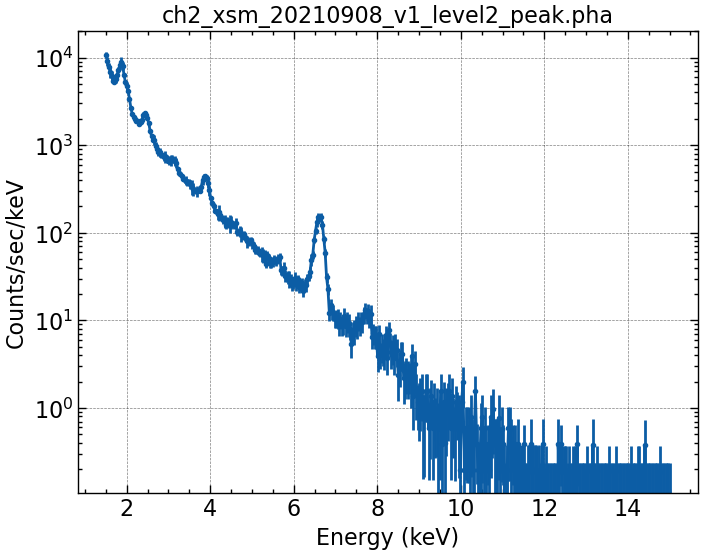

In [132]:
dplot1 = DataPlot()
dplot1.prepare(pha)
dplot1.plot(ylog=True,linestyle='solid')


### Model

In [133]:
class f_vth_sherpa(model.ArithmeticModel):
    def __init__(self,name='f_vth'):
        self.temperature = model.Parameter(name,'Temperature',10,min=1,hard_min=0)
        self.em = model.Parameter(name,'EM',1,min=1e-5,hard_min=1e-49)
        model.ArithmeticModel.__init__(self, name,(self.temperature,self.em))

    def calc(self,pars,x,*args,**kwargs):
        inds = (x>1.0002920302956426) & (x<100)
        x = x[inds]
        x = np.append(x,2*x[-1]-x[-2])
        ene = x*u.keV
        temp = pars[0]*1e6*u.K
        em = pars[1]*1e49/(u.cm**5)

        y = thermal_emission(ene,temp,em)

        spec = np.zeros(len(inds))
        spec[inds] = y

        return spec

mdl = f_vth_sherpa()
ene_x = pha.get_x()
print(mdl)

f_vth
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           


(1.0, 20.0)

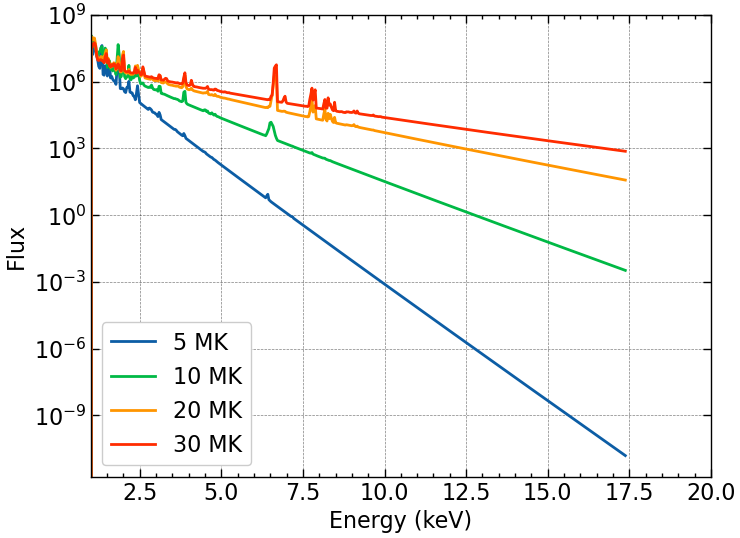

In [134]:
fig, ax = plt.subplots()
ax.semilogy(ene_x,mdl.calc([5,1],ene_x),label='5 MK')
ax.semilogy(ene_x,mdl.calc([10,1],ene_x),label='10 MK')
ax.semilogy(ene_x,mdl.calc([20,1],ene_x),label='20 MK')
ax.semilogy(ene_x,mdl.calc([30,1],ene_x),label='30 MK')
ax.legend()
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Flux')
ax.set_xlim([1,20])

In [135]:
xsm_rsp = Response1D(pha)
mdl_rsp = xsm_rsp(mdl)
print(mdl_rsp)

apply_rmf((180.0 * f_vth))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           


(1.0, 15.0)

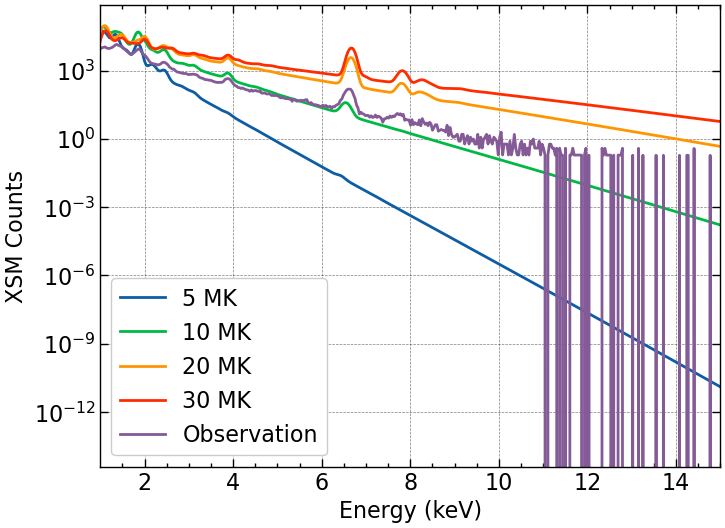

In [136]:
fig, ax = plt.subplots()
ax.semilogy(ene_x,mdl_rsp.calc([5,0.0018],ene_x),label='5 MK')
ax.semilogy(ene_x,mdl_rsp.calc([10,0.0018],ene_x),label='10 MK')
ax.semilogy(ene_x,mdl_rsp.calc([20,0.0018],ene_x),label='20 MK')
ax.semilogy(ene_x,mdl_rsp.calc([30,0.0018],ene_x),label='30 MK')
ax.semilogy(ene_x,pha.get_y(),label='Observation')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('XSM Counts')
ax.legend()
ax.set_xlim([1,15])

### Fitting to the model

In [137]:
pha = read_pha('ch2_xsm_20210908_v1_level2_peak.pha',use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(1.5,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1

mdl_rsp.model.pars[0].val = 10 # Temperature
mdl_rsp.model.pars[1].val = 0.01 #EM

fi = Fit(pha,mdl_rsp)

fres = fi.fit()
print(fres)
print(f'Reduced Chi2 = {fres.statval/fres.dof:.4f}')

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_vth.Temperature', 'f_vth.EM')
parvals        = (14.623040358077878, 0.0020025913424189436)
statval        = 1095.6055103176714
istatval       = 156625.3271047971
dstatval       = 155529.72159447943
numpoints      = 410
dof            = 408
qval           = 2.6326220293137047e-64
rstat          = 2.685307623327626
message        = successful termination
nfev           = 16
Reduced Chi2 = 2.6853


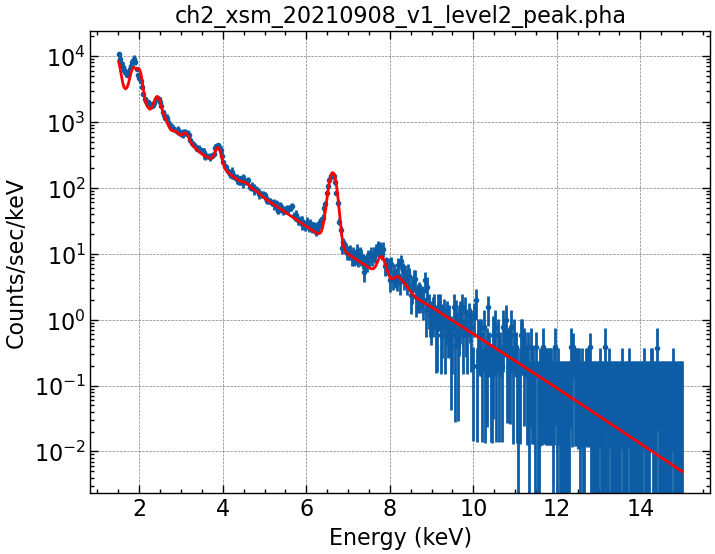

In [138]:
dplot = DataPlot()
dplot.prepare(fi.data)
mplot = ModelPlot()
mplot.prepare(fi.data, fi.model)
dplot.plot(ylog=True)
mplot.overplot(color='red')


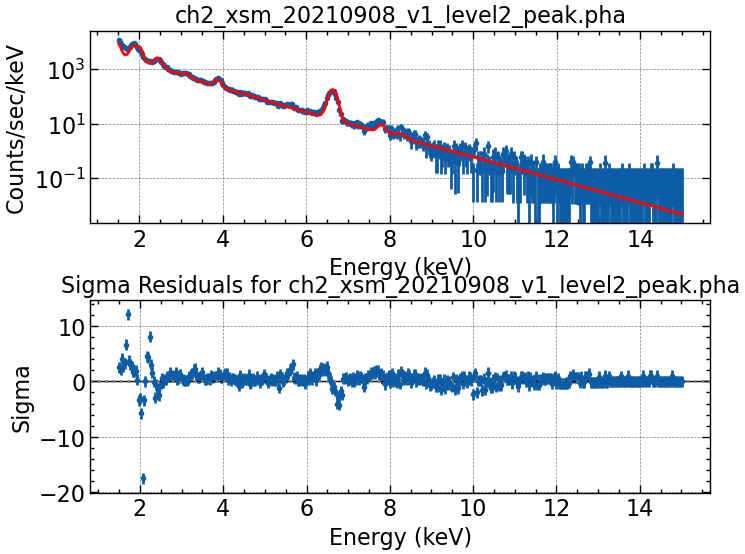

In [139]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPlot()
mplot = ModelPlot()

dplot.prepare(fi.data)
mplot.prepare(fi.data, fi.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi.data, fi.model, fi.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)

### Error Analysis

In [140]:
coverrs = fi.est_errors()
# print(coverrs)
print(coverrs.format())

coverrs.extra_output # covariance matrix

temp_errs = fi.est_errors(parlist=(mdl_rsp.model.pars[0], ))
em_errs = fi.est_errors(parlist=(mdl_rsp.model.pars[1], ))


Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   f_vth.Temperature       14.623   -0.0499765    0.0499765
   f_vth.EM       0.00200259 -1.33334e-05  1.33334e-05


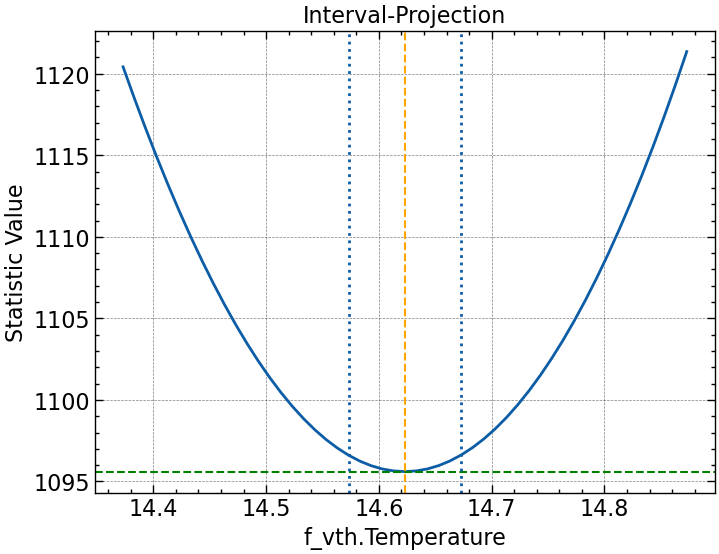

In [141]:
iproj = IntervalProjection()
iproj.prepare(fac=5, nloop=51)
iproj.calc(fi, mdl_rsp.model.pars[0])
iproj.plot()

pmin = temp_errs.parvals[0] + temp_errs.parmins[0]
pmax = temp_errs.parvals[0] + temp_errs.parmaxes[0]
iproj.vline(pmin, overplot=True, linestyle='dot')
iproj.vline(pmax, overplot=True, linestyle='dot')


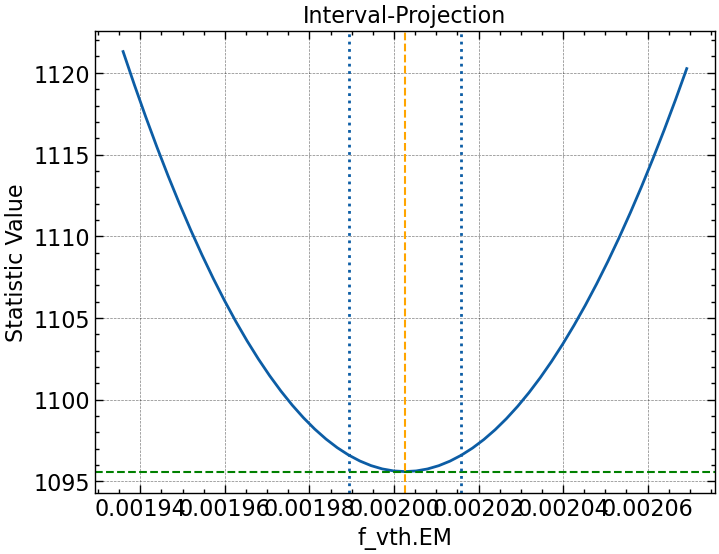

In [142]:
iproj = IntervalProjection()
iproj.prepare(fac=5, nloop=51)
iproj.calc(fi, mdl_rsp.model.pars[1])
iproj.plot()

pmin = em_errs.parvals[0] + em_errs.parmins[0]
pmax = em_errs.parvals[0] + em_errs.parmaxes[0]
iproj.vline(pmin, overplot=True, linestyle='dot')
iproj.vline(pmax, overplot=True, linestyle='dot')


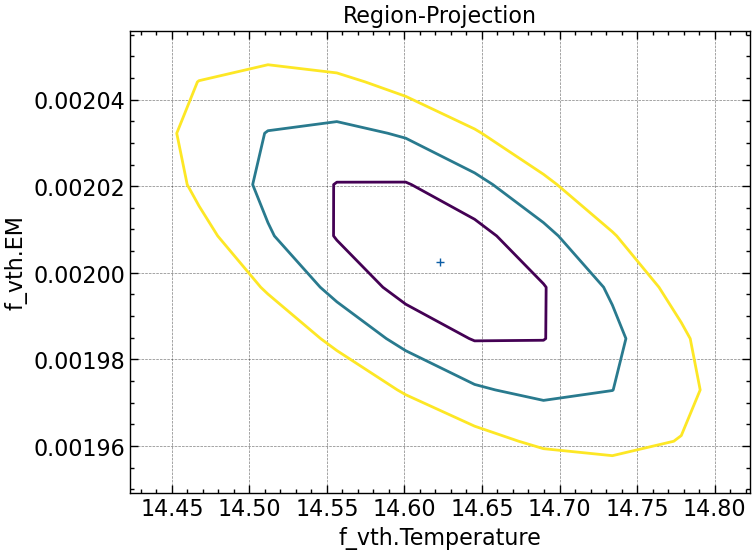

In [143]:
rproj = RegionProjection()
rproj.calc(fi, mdl_rsp.model.pars[0], mdl_rsp.model.pars[1])
rproj.contour()


### Changing statistics

In [144]:
fi_cash = Fit(pha,mdl_rsp,stat=CStat())

pha.notice(1.5,10)

fres_cash = fi_cash.fit()
print(fres_cash)
# print(f'Reduced Chi2 = {fres_chi2.statval/fres_chi2.dof:.4f}')

datasets       = None
itermethodname = none
methodname     = levmar
statname       = cstat
succeeded      = True
parnames       = ('f_vth.Temperature', 'f_vth.EM')
parvals        = (13.786377250184902, 0.0023705161245690903)
statval        = 55373.459523362755
istatval       = 83696.14240691274
dstatval       = 28322.682883549984
numpoints      = 410
dof            = 408
qval           = 0.0
rstat          = 135.7192635376538
message        = successful termination
nfev           = 10


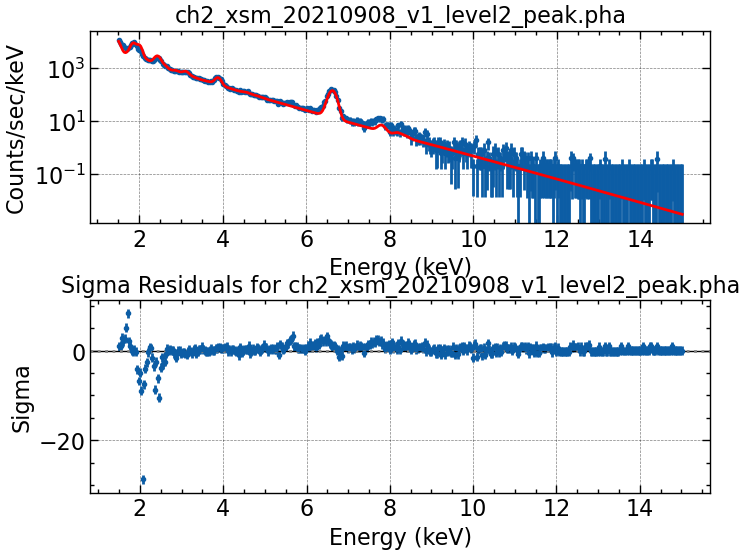

In [145]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPlot()
mplot = ModelPlot()

dplot.prepare(fi_cash.data)
mplot.prepare(fi_cash.data, fi_cash.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi_cash.data, fi_cash.model, fi_cash.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)

In [146]:
coverrs = fi.est_errors()
# print(coverrs)
print(coverrs.format())

coverrs.extra_output # covariance matrix

temp_errs = fi.est_errors(parlist=(mdl_rsp.model.pars[0], ))
em_errs = fi.est_errors(parlist=(mdl_rsp.model.pars[1], ))

Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   f_vth.Temperature      13.7864   -0.0598898    0.0598898
   f_vth.EM       0.00237052 -1.70085e-05  1.70085e-05


## Two Temperature

In [150]:
class f_2vth_sherpa(model.ArithmeticModel):
    def __init__(self,name='f_vth'):
        self.temperature1 = model.Parameter(name,'Temperature1',10,min=1,hard_min=0)
        self.em1 = model.Parameter(name,'EM1',1,min=1e-5,hard_min=1e-49)
        self.temperature2 = model.Parameter(name,'Temperature2',10,min=1,hard_min=0)
        self.em2 = model.Parameter(name,'EM2',1,min=1e-5,hard_min=1e-49)
        
        model.ArithmeticModel.__init__(self, name,(self.temperature1,self.em1,self.temperature2,self.em2))

    def calc(self,pars,x,*args,**kwargs):
        inds = (x>1.0002920302956426) & (x<100)
        x = x[inds]
        x = np.append(x,2*x[-1]-x[-2])
        ene = x*u.keV
        temp1 = pars[0]*1e6*u.K
        em1 = pars[1]*1e49/(u.cm**5)
        temp2 = pars[2]*1e6*u.K
        em2 = pars[3]*1e49/(u.cm**5)
        
        y = thermal_emission(ene,temp1,em1) + thermal_emission(ene,temp2,em2)

        spec = np.zeros(len(inds))
        spec[inds] = y

        return spec

mdl_2vth = f_2vth_sherpa()
mdl_2vth_rsp = xsm_rsp(mdl_2vth)
print(mdl_2vth_rsp)

apply_rmf((180.0 * f_vth))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature1 thawed           10            1  3.40282e+38           
   f_vth.EM1    thawed            1        1e-05  3.40282e+38           
   f_vth.Temperature2 thawed           10            1  3.40282e+38           
   f_vth.EM2    thawed            1        1e-05  3.40282e+38           


In [151]:
pha = read_pha('ch2_xsm_20210908_v1_level2_peak.pha',use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(1.3,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1

mdl_2vth_rsp.model.pars[0].val = 10 # Temperature
mdl_2vth_rsp.model.pars[1].val = 0.01 #EM
mdl_2vth_rsp.model.pars[2].val = 10 # Temperature
mdl_2vth_rsp.model.pars[3].val = 0.01 #EM


fi = Fit(pha,mdl_2vth_rsp)

fres = fi.fit()
print(fres)
print(f'Reduced Chi2 = {fres.statval/fres.dof:.4f}')

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_vth.Temperature1', 'f_vth.EM1', 'f_vth.Temperature2', 'f_vth.EM2')
parvals        = (6.506487209963689, 0.0014125929384668891, 15.339409972218789, 0.0016493984203785224)
statval        = 877.1072816156519
istatval       = 1018325.4740302794
dstatval       = 1017448.3667486638
numpoints      = 416
dof            = 412
qval           = 9.793721220502302e-36
rstat          = 2.128901168970029
message        = successful termination
nfev           = 170
Reduced Chi2 = 2.1289


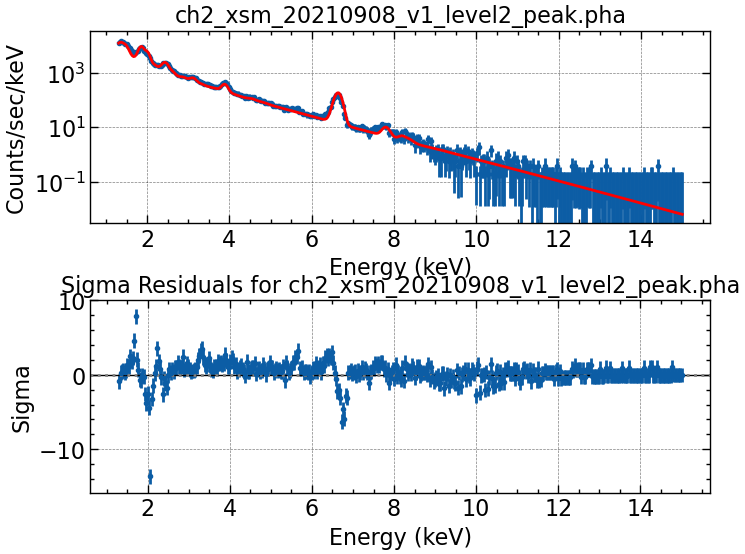

In [152]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPlot()
mplot = ModelPlot()

dplot.prepare(fi.data)
mplot.prepare(fi.data, fi.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi.data, fi.model, fi.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)

## Pre-Flare

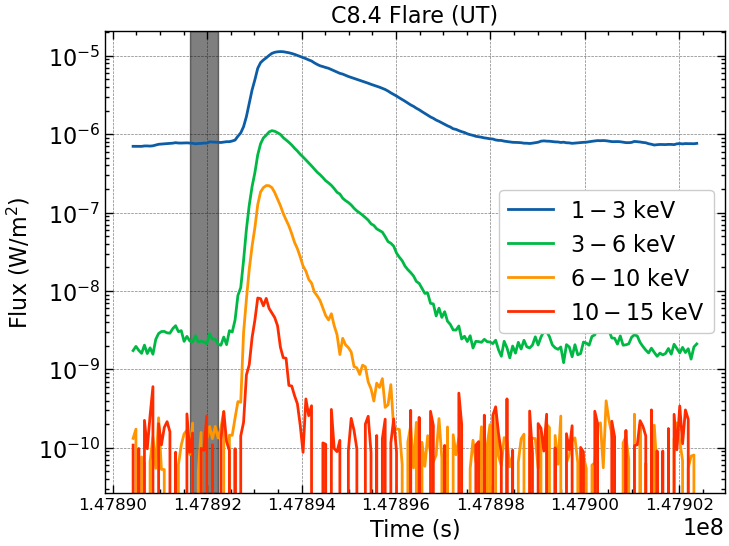

In [82]:
alltime, allflux_1_3, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',1,3)
alltime, allflux_3_6, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',3,6)
alltime, allflux_6_10, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',6,10)
alltime, allflux_10_15, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',10,15)
# alltime = alltime - alltime.min()
fig, ax = plt.subplots()
ax.semilogy(alltime[1000:1200],allflux_1_3[1000:1200],label=r'$1 - 3$ keV')
ax.semilogy(alltime[1000:1200],allflux_3_6[1000:1200],label=r'$3 - 6$ keV')
ax.semilogy(alltime[1000:1200],allflux_6_10[1000:1200],label=r'$6 - 10$ keV')
ax.semilogy(alltime[1000:1200],allflux_10_15[1000:1200],label=r'$10 - 15$ keV')
ax.axvspan(alltime[1020],alltime[1030],alpha=0.5, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.legend()
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('C8.4 Flare (UT)');

In [87]:
xsm_genspec('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',alltime[1020],alltime[1030],'ch2_xsm_20210908_v1_level2_preflare')

In [90]:
pha_pre = read_pha('ch2_xsm_20210908_v1_level2_preflare.pha',use_errors=True)
print(pha_pre)

name           = ch2_xsm_20210908_v1_level2_preflare.pha
channel        = Float64[512]
counts         = Float64[512]
staterror      = Float32[512]
syserror       = Float64[512]
bin_lo         = None
bin_hi         = None
grouping       = None
quality        = None
exposure       = 660.0
backscal       = None
areascal       = None
grouped        = False
subtracted     = False
units          = channel
rate           = True
plot_fac       = 0
response_ids   = []
background_ids = []


In [157]:
pha_pre = read_pha('ch2_xsm_20210908_v1_level2_preflare.pha',use_errors=True)
pha_pre.set_rmf(rmf)
pha_pre.set_analysis('energy')
pha_pre.notice(1.3,5)

xsm_rsp_pre = Response1D(pha_pre)
mdl_rsp_pre = xsm_rsp_pre(mdl)
print(mdl_rsp_pre)

pha_pre.staterror[pha_pre.staterror==0] = 1
pha_pre.syserror[pha_pre.syserror == 0] = 1

mdl_rsp_pre.model.pars[0].val = 10 # Temperature
mdl_rsp_pre.model.pars[1].val = 0.01 #EM

fi_pre = Fit(pha_pre,mdl_rsp_pre)

fres_pre = fi_pre.fit()
print(fres_pre)
print(f'Reduced Chi2 = {fres_pre.statval/fres_pre.dof:.4f}')

apply_rmf((660.0 * f_vth))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed      13.7864            1  3.40282e+38           
   f_vth.EM     thawed   0.00237052        1e-05  3.40282e+38           
datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_vth.Temperature', 'f_vth.EM')
parvals        = (4.44680382086592, 0.0005947551180000398)
statval        = 36.64747991726304
istatval       = 236891432.06871402
dstatval       = 236891395.4212341
numpoints      = 113
dof            = 111
qval           = 0.9999999999978563
rstat          = 0.3301574767320995
message        = successful termination
nfev           = 36
Reduced Chi2 = 0.3302


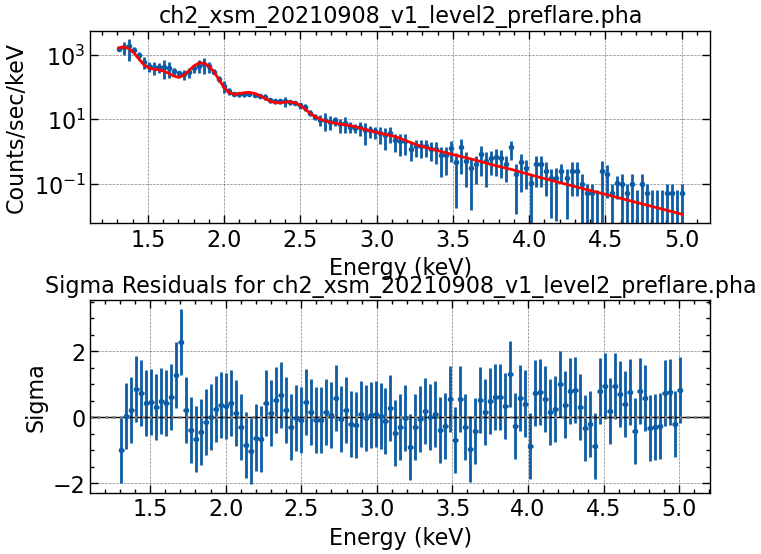

In [99]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPlot()
mplot = ModelPlot()

dplot.prepare(fi_pre.data)
mplot.prepare(fi_pre.data, fi_pre.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi_pre.data, fi_pre.model, fi_pre.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)